# **Project: Remaining Useful Life Prediction**

##  Task: RUL Prediction using LSTM

This project aims to develop a deep learning model based on Long Short-Term Memory (LSTM) networks to predict the Remaining Useful Life (RUL) of jet engines. The dataset used is the NASA Turbofan Engine Degradation Simulation Dataset, which contains time-series sensor readings from multiple engines operating under varying conditions. The goal is to capture long-term dependencies in sensor data and estimate the number of operational cycles remaining before engine failure.

### Data: 

To effectively model the patterns of engine degradation, a sliding window approach with a window size of (30, 14) has been applied. This ensures that each training sample includes 30 consecutive time steps with 14 sensor features per step, enabling the model to learn degradation trends over time.

- X_train data shape:  (14184, 30, 14)
- y_train data shape:  (14184,)
- X_val data shape:  (3547, 30, 14)
- y_val data shape:  (3547,)
- X_test data shape:  (100, 30, 14)
- y_test data shape:  (100,)

### Model Architecture: LSTM for Time-Series Regression

The LSTM model is designed to process sequential sensor data and predict the RUL of an engine at a given time step. LSTM networks are well-suited for time-series forecasting due to their ability to retain **long-term dependencies**.


This article discussed techniques used to improve tye LSTM model performance:

https://medium.com/@yousufdata/6-tips-to-tweak-your-lstm-bilstm-15fd02685c8


### Result:
- MAE: 9.90
- RMSE: 14.69
- Score: 359.45

Score function for prognostics:

The function penalizes late predictions more than early ones, which is crucial for Remaining Useful Life (RUL) prediction.

In [2]:
__author__ = "Bing Huang"
__email__ = "Binghuang1990@gmail.com"

# **0. Load Dependencies**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import random

# Set all possible seeds
seed = 42
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.10.0


# **1. Load Data**

In [5]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

In [6]:
print("X_train data shape: ", X_train.shape)
print("y_train data shape: ", y_train.shape)
print("X_val data shape: ", X_val.shape)
print("y_val data shape: ", y_val.shape)
print("X_test data shape: ", X_test.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (14184, 30, 14)
y_train data shape:  (14184,)
X_val data shape:  (3547, 30, 14)
y_val data shape:  (3547,)
X_test data shape:  (100, 30, 14)
y_test data shape:  (100,)


# **2. Build and Train a LSTM Model**

In [7]:

input_shape = (X_train.shape[1], X_train.shape[2])  # （30， 14）

#----------------
# Create a CNN model
#------------------
model = Sequential()

#----------------
# Add 3 LSTM layers
#------------------
model.add(LSTM(units=56, activation='tanh',return_sequences=True, input_shape=input_shape))
model.add(LSTM(units=28, activation='tanh', return_sequences=True))  # activation function = tanh by default
model.add(LSTM(units=14, activation='tanh', return_sequences=False))

#---------------------------
# Add fully connected layers
#---------------------------
model.add(Dense(14, activation = "relu"))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 56)            15904     
                                                                 
 lstm_1 (LSTM)               (None, 30, 28)            9520      
                                                                 
 lstm_2 (LSTM)               (None, 14)                2408      
                                                                 
 dense (Dense)               (None, 14)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 15        
                                                                 
Total params: 28,057
Trainable params: 28,057
Non-trainable params: 0
_________________________________________________________________


In [8]:
optimizers_adam = Adam(learning_rate = 0.001)

model.compile(
    optimizer=optimizers_adam , 
    loss='mse',
    metrics=['mae']  # Evaluation metric
)

In [9]:

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor (validation loss)
    patience=10,             # Number of epochs with no improvement in val_loss before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)


history = model.fit(X_train, 
            y_train, 
            epochs=100,
            batch_size=32, 
            validation_data=(X_val, y_val), 
            verbose=1,
            callbacks=[early_stopping])

Epoch 1/100
444/444 [==============================] - 8s 9ms/step - loss: 4938.9023 - mae: 58.3178 - val_loss: 2398.5991 - val_mae: 39.8743
Epoch 2/100
444/444 [==============================] - 4s 8ms/step - loss: 844.0395 - mae: 22.1585 - val_loss: 325.3665 - val_mae: 15.4595
Epoch 3/100
444/444 [==============================] - 4s 8ms/step - loss: 224.4218 - mae: 11.8431 - val_loss: 209.9569 - val_mae: 11.5204
Epoch 4/100
444/444 [==============================] - 4s 8ms/step - loss: 179.5464 - mae: 9.9949 - val_loss: 182.8047 - val_mae: 10.0603
Epoch 5/100
444/444 [==============================] - 4s 8ms/step - loss: 163.8514 - mae: 9.3374 - val_loss: 198.8394 - val_mae: 10.5632
Epoch 6/100
444/444 [==============================] - 4s 8ms/step - loss: 156.8820 - mae: 9.0984 - val_loss: 203.2427 - val_mae: 9.9668
Epoch 7/100
444/444 [==============================] - 4s 8ms/step - loss: 147.1223 - mae: 8.7409 - val_loss: 224.8020 - val_mae: 11.0514
Epoch 8/100
444/444 [=========

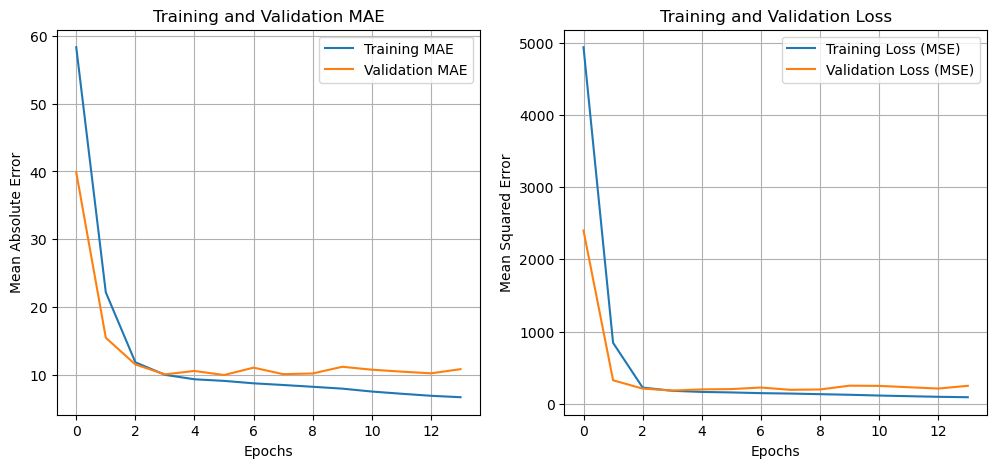

In [10]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.grid()
plt.title('Training and Validation MAE')

# Plot MSE
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss (MSE)')
plt.plot(val_loss, label='Validation Loss (MSE)')
plt.legend()
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.grid()
plt.title('Training and Validation Loss')

plt.show()

# **3. Model Prediction and Evaluation**

In [11]:
model.predict(X_test).reshape(-1) # reshape to 1d array

4/4 [==============================] - 0s 3ms/step


array([108.351974 , 119.63856  ,  47.21334  ,  89.43685  , 111.265915 ,
       111.26093  , 106.63244  , 103.8298   , 118.87774  ,  96.450264 ,
        86.33302  , 105.72303  ,  92.155136 , 105.51769  , 104.29401  ,
       111.262276 ,  47.62389  ,  31.127544 , 103.57102  ,  16.815435 ,
        90.07175  , 121.06526  , 120.067055 ,  18.301537 , 119.514595 ,
       115.674095 , 101.37793  , 116.88714  , 110.18973  , 109.42453  ,
         8.50739  ,  55.777653 , 111.27213  ,   5.259227 ,  10.423431 ,
        22.203178 ,  25.258242 ,  56.389397 , 121.06037  ,  32.182247 ,
        23.61874  ,  11.245325 ,  63.966263 , 116.69439  ,  75.54354  ,
        40.478584 , 111.754906 , 110.18595  ,  15.9441805,  92.555244 ,
       116.69001  ,  37.77916  ,  29.99799  , 116.43683  , 120.93075  ,
        14.312593 , 106.11097  ,  51.654037 , 109.163155 , 114.51638  ,
        20.03063  ,  45.52384  ,  84.38386  ,  22.695955 , 121.24993  ,
        16.781788 , 120.53608  ,   8.360318 , 120.44931  , 102.7

In [12]:
y_test

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

In [13]:

# Predict RUL using the trained model
y_pred = model.predict(X_test).reshape(-1)  # Ensure it’s a 1D array

y_test = np.clip(y_test, a_min=0, a_max=125)  
y_pred = np.clip(y_pred, a_min=0, a_max=125)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")



4/4 [==============================] - 0s 4ms/step
RMSE: 13.69
MAE: 9.90


In [14]:

def score_function(y_true, y_pred):
    """
    Computes the prognostics-specific score function.
    Penalizes late predictions more than early ones.
    """
    error = y_pred - y_true  
    score = np.where(error < 0, np.exp(-error / 13) - 1, np.exp(error / 10) - 1)
    return np.sum(score)

score = score_function(y_test, y_pred)
print(f"score: {score:.2f}")

score: 359.45


In [15]:
# save the model
model.save("LSTM_trained_model.h5")  # Save in HDF5 format

# **4. Visualization Model Performance**

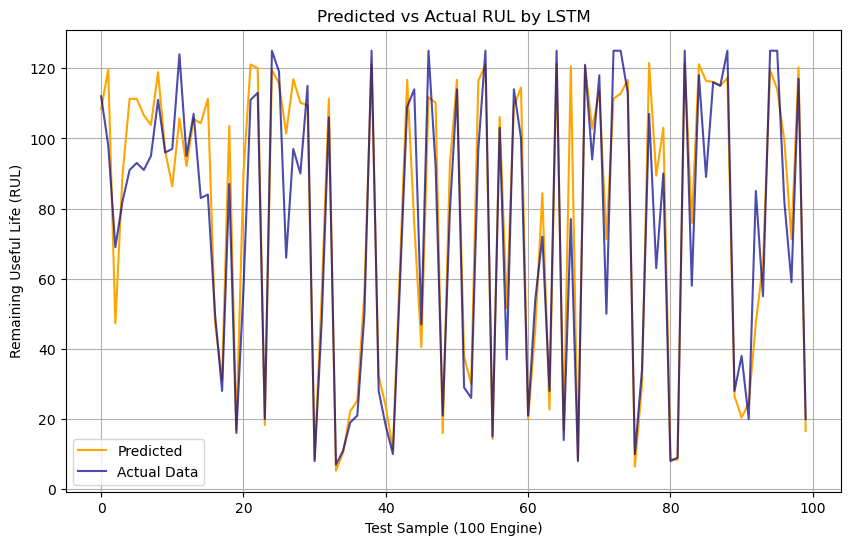

In [16]:
plt.figure(figsize=(10,6))
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="orange", alpha=1)
plt.plot(range(len(y_test)), y_test, label="Actual Data", color="darkblue", alpha=0.7)
plt.xlabel("Test Sample (100 Engine)")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("Predicted vs Actual RUL by LSTM")

plt.legend()
plt.grid()
plt.show()

C:\Users\bingh\AppData\Local\Temp\ipykernel_1468\2976239720.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_indices, y=errors, palette=bar_colors)
C:\Users\bingh\AppData\Local\Temp\ipykernel_1468\2976239720.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


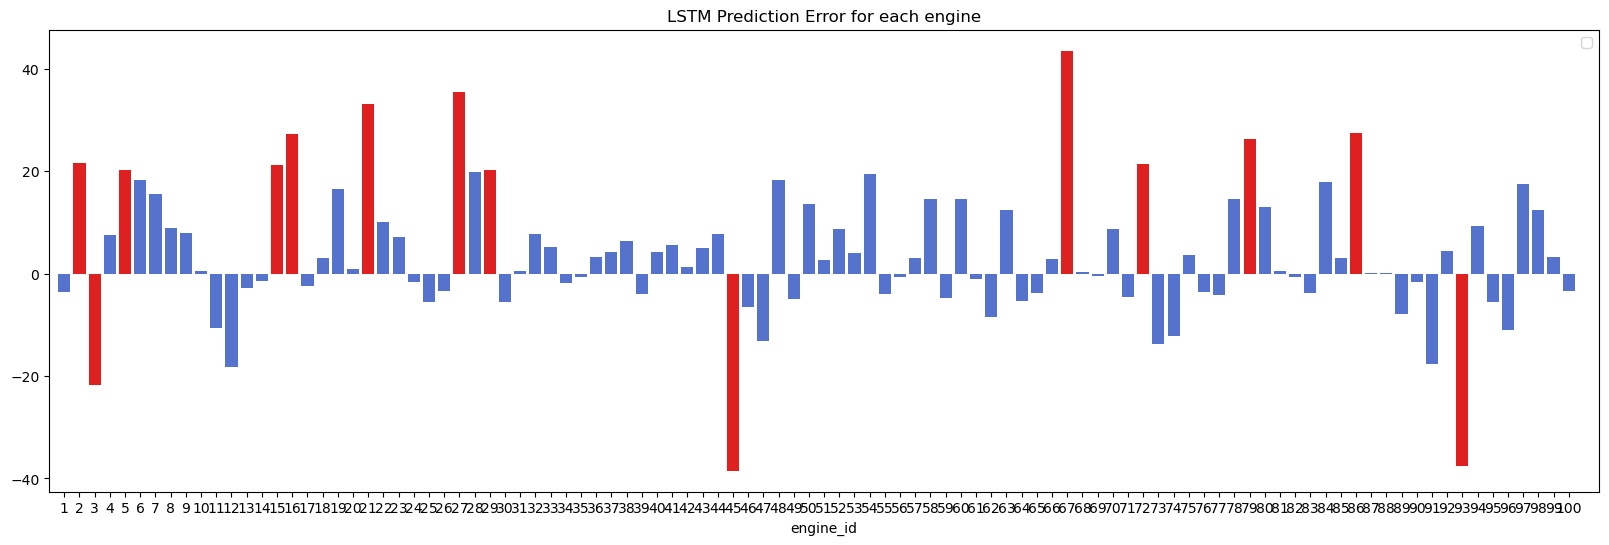

In [ ]:
# plot the prediction errors

errors = y_pred - y_test
bar_colors = ['red' if abs(error) > 20 else "royalblue" for error in errors]
# Create an index for x-axis (1 to 100)
x_indices = np.arange(1, len(errors) + 1)

plt.figure(figsize=(20, 6))
sns.barplot(x=x_indices, y=errors, palette=bar_colors)
plt.xlim(-1, 101)
plt.xlabel("engine_id")
plt.title("LSTM Prediction Error for each engine")

plt.show()